In [2]:
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from tqdm import tqdm
import argparse

class AdmissionsDataset(Dataset):
    """Dataset class for loading and accessing admissions data."""
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)


class MLP(nn.Module):
    """Multi-layer perceptron model for classifying admissions data."""
    def __init__(self, input_dim=14, hidden_dim=64, output_dim=4):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.activation(self.lin1(x))
        x = self.activation(self.lin2(x))
        x = self.lin3(x)
        return x
    
    def save_representations(self, x):
        """Save intermediate representations for analysis."""
        np.save('data/original_rep.npy', x.detach().numpy())
        x = self.activation(self.lin1(x))
        np.save('data/layer1_rep.npy', x.detach().numpy())
        x = self.activation(self.lin2(x))
        np.save('data/layer2_rep.npy', x.detach().numpy())

class AdmissionsClassifier:
	"""Class for handling data loading, preprocessing, training, and testing the MLP model."""
	def __init__(self, args):
		self.batch_size = args.batch_size
		self.train_epoch = args.train_epoch
		self.lr = args.lr
		self.verbose = args.verbose
		self.data_path = args.data_path
		self.model = MLP()
	
	def load_data(self):
		"""Load and preprocess the data from the CSV file."""
		def to_float(input):
			return float(input) if input else -1

		def format_row(row):
			features = [to_float(row[col]) for col in 
						['satv_use', 'satm_use', 'satcomp_use', 'act_eng', 
						 'act_math', 'act_read', 'act_sci', 'act_comp', 
						 'nc1', 'nc2', 'nc3', 'ncav', 'hs_gpa', 'college_gpa']]
			# labels: [Admit, Denied, Waitlisted, Others]
			label = [0, 0, 0, 0]
			if row['vt_adm_dec'] == 'admitted':
				label[0] = 1
			elif row['vt_adm_dec'] == 'rejected':
				label[1] = 1
			elif row['vt_adm_dec'] == 'waitlisted':
				label[2] = 1
			return features, label

		with open(self.data_path, 'r', newline='', encoding='utf-8') as file:
			reader = csv.DictReader(file)
			data, labels = zip(*[format_row(row) for row in reader])

		data = np.array(data)
		data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0) + 1e-6)
		labels = np.array(labels)
		
		train_size = int(len(data) * 0.8)
		indices = list(range(len(data)))
		random.shuffle(indices)
		
		train_indices = indices[:train_size]
		test_indices = indices[train_size:]
		
		train_data = data[train_indices]
		test_data = data[test_indices]
		train_labels = labels[train_indices]
		test_labels = labels[test_indices]

		self.train_loader = DataLoader(AdmissionsDataset(train_data, train_labels), batch_size=self.batch_size, shuffle=True)
		self.test_loader = DataLoader(AdmissionsDataset(test_data, test_labels), batch_size=self.batch_size, shuffle=False)
	
	def train(self):
		"""Train the model on the training dataset."""
		optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
		criterion = nn.CrossEntropyLoss()
		
		for epoch in tqdm(range(self.train_epoch)):
			for batch_idx, (data, labels) in enumerate(self.train_loader):
				data = data.float()
				labels = labels.float()
				
				optimizer.zero_grad()
				predictions = self.model(data)
				loss = criterion(predictions, labels)
				loss.backward()
				optimizer.step()
				
				if batch_idx % self.verbose == 0:
					print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")
			print(f"Epoch {epoch}, Test Accuracy: {self.test_accuracy()}")
	
	def test_accuracy(self):
		"""Compute accuracy on the test dataset."""
		correct = 0
		total = 0
		with torch.no_grad():
			for data, labels in self.test_loader:
				data = data.float()
				predictions = self.model(data)
				predicted_labels = torch.argmax(predictions, dim=1)
				actual_labels = torch.argmax(labels, dim=1)
				correct += (predicted_labels == actual_labels).sum().item()
				total += labels.size(0)
		return correct / total
	
	def save_representations(self):
		"""Save representations from various model layers."""
		sample_data, _ = next(iter(self.train_loader))
		self.model.save_representations(sample_data.float())

		

In [3]:
# Parsing arguments
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', 
                    type=int, 
                    default=300, 
                    help='the number of data samples processed together in one forward and backward pass')
parser.add_argument('--train_epoch', type=int, default=5)
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate hyperameter')
parser.add_argument('--verbose', type=int, default=10)
parser.add_argument('--data_path', type=str, default='data.csv')
args = parser.parse_args(args=['--data_path', 'data/ext_dataset1.csv'])

model = AdmissionsClassifier(args)
model.load_data()
len(model.test_loader.dataset)
# model.train()

40

/opt/anaconda3/envs/cs5805/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [8]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


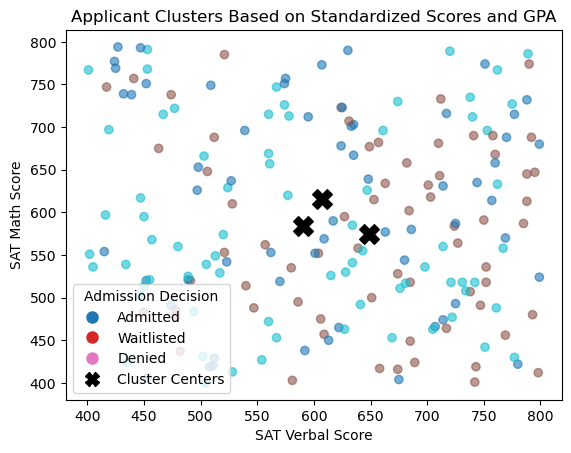

array([0, 2, 1, 2, 1, 1, 1, 1, 1, 0], dtype=int32)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def cluster_score(data, cluster_labels):

    imputer = SimpleImputer(strategy='mean')
    imputed_data = imputer.fit_transform(data)
    
    original_min = imputed_data.min(axis=0)
    original_max = imputed_data.max(axis=0)
    normalized_data = (imputed_data - original_min) / (original_max - original_min + 1e-6)
    
    n_clusters = len(cluster_labels)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(normalized_data)
    
    unnormalized_centers = kmeans.cluster_centers_ * (original_max - original_min + 1e-6) + original_min
    
    scatter = plt.scatter(imputed_data[:, 0], imputed_data[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.scatter(unnormalized_centers[:, 0], unnormalized_centers[:, 1], s=200, c='black', marker='X', label='Cluster Centers')
    plt.title("Applicant Clusters Based on Standardized Scores and GPA")
    plt.xlabel("SAT Verbal Score")
    plt.ylabel("SAT Math Score")
    
    # Update legend with matching colors for each cluster
    unique_labels = np.unique(labels)
    handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(i/n_clusters), 
                          markerfacecolor=scatter.cmap(i/n_clusters), markersize=8, linestyle='') for i in unique_labels]
    handles.append(plt.Line2D([0], [0], marker='X', color='black', markersize=10, linestyle='', label='Cluster Center'))
    
    plt.legend(handles, cluster_labels + ['Cluster Centers'], title="Admission Decision")
    plt.show()
    
    return labels

data_df = pd.read_csv('data/ext_dataset2.csv')
score_columns = ['satv_use', 'satm_use', 'act_eng', 'act_math', 'act_read', 'act_sci', 'act_comp', 'hs_gpa', 'college_gpa']
score_data = data_df[score_columns].values  
admission_labels = ['Admitted', 'Waitlisted', 'Denied']

cluster_labels_with_admission = cluster_score(score_data, admission_labels)
cluster_labels_with_admission[:10] 
